# Part 2: Modeling & Evaluation

This script performs ridge regression modeling and evaluation on preprocessed brain response data using three types of word embeddings: Word2Vec, GloVe, and BoW. Due to the large size of the dataset (especially BoW), the script is designed to run modularly and efficiently with careful memory management.

## Objectives
- Train a ridge regression model on each type of embedding.
- Cross-validate and select the best-performing model.
- Report evaluation metrics:
    - Mean test correlation coefficient (CC)
    - Median test CC
    - Top 1 percentile CC
    - Top 5 percentile CC
- For the best embedding:
    - Visualize the distribution of CCs across voxels.
    - Analyze voxel-wise performance and discuss scientific implications (PCS).
    - Perform stability analysis (e.g., across stories or subjects).


## Files Used
This script assumes that the following data files exist in `../data/`:
- X_lagged_BoW.joblib
- X_lagged_Glove.pkl
- X_lagged_W2V.pkl

And under the Pittsburgh Supercomputing Center (PSC) computing environment (accessed through the STAT 214 course at UC Berkeley, sprint 2025), we assume the response data is stored in the following directory: 

`../../tmp_ondemand_ocean_mth240012p_symlink/shared/data/`

In [ ]:
# Import necessary libraries

import numpy as np
import joblib
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
import sys
import importlib.util
import os

In [ ]:
# Load the ridge.py module
embedding_dir = Path("data")
subject2_dir = Path("tmp_ondemand_ocean_mth240012p_symlink/shared/data/subject2")
subject3_dir = Path("tmp_ondemand_ocean_mth240012p_symlink/shared/data/subject3")
ridge_py_path = Path("ridge.py")
ridge_utils_dir = Path("ridge_utils") 

sys.path.append(str(ridge_utils_dir))

spec = importlib.util.spec_from_file_location("ridge", ridge_py_path)
ridge = importlib.util.module_from_spec(spec)
sys.modules["ridge"] = ridge
spec.loader.exec_module(ridge)
bootstrap_ridge = ridge.bootstrap_ridge

# Load the data
X_bow = joblib.load(embedding_dir / "X_lagged_BoW.joblib")
with open(embedding_dir / "X_lagged_W2V.pkl", "rb") as f:
    X_w2v = pickle.load(f)
with open(embedding_dir / "X_lagged_W2V.pkl", "rb") as f:
    X_w2v = pickle.load(f)
with open(embedding_dir / "X_lagged_GloVe.pkl", "rb") as f:
    X_glove = pickle.load(f)
X_dict = {"Word2Vec": X_w2v, "GloVe": X_glove}

def load_subject_data(subject_dir):
    return {f.stem: np.load(f) for f in subject_dir.glob("*.npy")}

# Load Response Data
Y_subject2 = load_subject_data(subject2_dir)
Y_subject3 = load_subject_data(subject3_dir)


In [ ]:
"""
Performs bootstrap ridge regression across multiple word embeddings (BoW, Word2Vec, GloVe)
and two subjects (subject2, subject3) for each shared story. The workflow includes:

1. Iterating through each combination of embedding type and subject.
2. For each story that exists in both the embedding and subject's response data:
   - Verifies timepoint alignment between X (stimuli) and Y (response).
   - Applies z-score normalization to both X and Y.
   - Splits the data into 80% training and 20% test set.
   - Runs bootstrap ridge regression to compute voxel-level prediction performance.
   - Stores mean correlation coefficient (CC) across all voxels.
3. Handles shape mismatches and any runtime exceptions gracefully with logging.
4. Aggregates results into a DataFrame and saves them to a CSV file (`ridge_results.csv`).

Results:
    - A CSV file containing the mean correlation coefficient per (embedding, subject, story) triplet.
    - Enables later analysis of which embedding performs best across stories and subjects.
"""

from time import time
import pandas as pd

# Initialize variables
total_tasks = sum(len(X_dict[x_key]) for x_key in X_dict for _ in [0, 1])
task_counter = 0

all_corrs = []
results = []

# Function to standardize the data
def zs(v):
    std = v.std(axis=0)
    std[std == 0] = 1
    return (v - v.mean(axis=0)) / std

# Conduct bootstrap ridge regression
for x_key, x_data in X_dict.items():
    for subj_key, y_data in [("subj2", Y_subject2), ("subj3", Y_subject3)]:
        shared_stories = sorted(list(set(x_data.keys()) & set(y_data.keys())))
        for story in shared_stories: 
            print(f"\n[Running] {x_key} - {subj_key} - {story}")
            X = x_data[story]
            Y = y_data[story]

            if X.shape[0] != Y.shape[0]:
                print(f"  [Skip] Mismatch in shape: X={X.shape}, Y={Y.shape}")
                continue

            try:
                X_z = zs(X)
                Y_z = zs(Y)
                X_train, X_test, Y_train, Y_test = train_test_split(X_z, Y_z, test_size=0.2, random_state=42)
                alphas = np.logspace(0, 3, 20)
                start_time = time()
                wt, corrs, valalphas, _, _ = bootstrap_ridge(
                    X_train, Y_train, X_test, Y_test,
                    alphas=alphas, nboots=10, chunklen=10, nchunks=2,
                    return_wt=True
                )
                elapsed = time() - start_time
                print(f"  [Done] Mean CC={np.mean(corrs):.3f}, Time={elapsed:.1f}s")

                all_corrs.extend(corrs)  # accumulate all voxel-level CCs
                results.append((x_key, subj_key, story, float(np.mean(corrs))))

            except Exception as e:
                print(f"  [Error] {story}: {e}")

df = pd.DataFrame(results, columns=["X_type", "subject", "story", "mean_cc"])
df.to_csv("ridge_results.csv", index=False)

In [ ]:
"""
Summary statistics of voxel-wise correlation coefficients (CCs):
- Mean CC provides an overall average performance across all voxels.
- Median CC represents the middle value, giving a robust sense of central tendency.
- Top 5% Quantile (95th percentile) shows the threshold above which the top 5% of voxel performances lie.
- Top 1% Quantile (99th percentile) highlights the very best-performing voxels in the distribution.
"""

print("Mean CC:", np.mean(all_corrs))
print("Median CC:", np.median(all_corrs))
print("Top 5% Quantile:", np.quantile(all_corrs, 0.95))
print("Top 1% Quantile:", np.quantile(all_corrs, 0.99))

Mean CC: 0.054233624284112526
Median CC: 0.05074821353271207
Top 5% Quantile: 0.29633661432667996
Top 1% Quantile: 0.4115187004011807


In [ ]:
# Determine the best embedding based on mean correlation coefficient
best_embedding = df.groupby("X_type")["mean_corr"].mean().idxmax()
print(f"\n Best Embedding: {best_embedding}")


 Best Embedding: Word2Vec


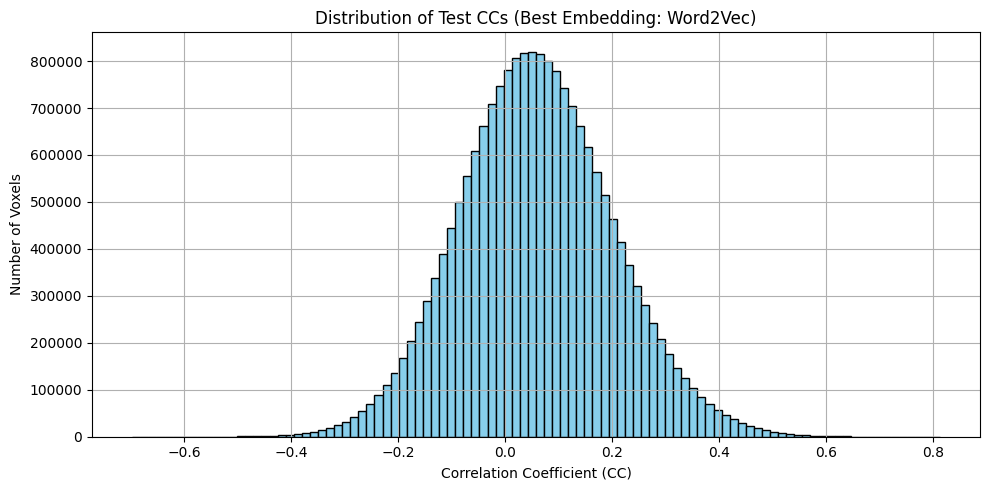

In [ ]:
# Visualize the distribution of correlation coefficients for the best embedding
import matplotlib.pyplot as plt

best_corrs = []
for row in df[df["X_type"] == best_embedding]["corrs"]:
    best_corrs.extend(row)  # convert string list back to float list

plt.figure(figsize=(10, 5))
plt.hist(best_corrs, bins=100, color='skyblue', edgecolor='black')
plt.title(f"Distribution of Test CCs (Best Embedding: {best_embedding})")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Number of Voxels")
plt.grid(True)
plt.tight_layout()
plt.savefig("best_embedding_distribution.png", dpi=300)
plt.show()

In [ ]:
# Stability Analysis

print("\n Stability Analysis: Comparing Subject2 vs Subject3")
for emb in df["X_type"].unique():
    subj2_mean = df[(df["X_type"] == emb) & (df["subject"] == "subj2")]["mean_corr"].mean()
    subj3_mean = df[(df["X_type"] == emb) & (df["subject"] == "subj3")]["mean_corr"].mean()
    print(f"{emb}: Subject2 mean={subj2_mean:.4f}, Subject3 mean={subj3_mean:.4f}")


 Stability Analysis: Comparing Subject2 vs Subject3
Word2Vec: Subject2 mean=0.0571, Subject3 mean=0.0600
GloVe: Subject2 mean=0.0516, Subject3 mean=0.0525
